In [77]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
sns.set_theme()

np.random.seed(12)
random.seed(12)

In [78]:
def preprocess_image(path, size=32): 
    ''' 
    Resize to fixed size (32x32),
    Convert to grayscale (L = grayscale),
    Binarize (white=+1, black=-1),
    Flatten to 1D vector 
    '''
    
    img = Image.open(path).convert('L')  
    img = img.resize((size, size))

    img_array = np.array(img)

    # binarize pixels where > 127 is 1, else -1 (threshold)
    binary_array = np.where(img_array > 127, 1, -1)

    return binary_array.flatten()

In [79]:
def show_image(img_vector, size=32, title=''):
    ''' 
    Sanity check (bc I want to see the images)
    '''
    reshaped = img_vector.reshape((size, size))
    plt.imshow(reshaped, cmap='gray') 
    plt.title(title)
    plt.axis('off')
    plt.show()

In [80]:
def load_all_images(image_dir, size=32):
    ''' 
    Upload all images ("memories") to our computational brain :3
    '''
    memory_dict = {}
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            label = filename[:-4] 
            path = os.path.join(image_dir, filename)
            memory_dict[label] = preprocess_image(path, size)
    return memory_dict

In [81]:
# MEMORY ENCODING
def train_hopfield(patterns, repeats=1):
    '''
    Train network via Hebbian learning!
    W = sum(outer products of each pattern with itself)
    '''
    n = len(next(iter(patterns)))  
    W = np.zeros((n, n))

    for i in range(repeats):
        for pattern in patterns:
            W += np.outer(pattern, pattern) # HEBBIAN LEARNING

    np.fill_diagonal(W, 0)  # prevents self-connections
    W /= len(patterns)
    return W

In [82]:
# PATTERN RETRIEVAL 
def recall_pattern(W, pattern, steps=10, tolerance=0):
    '''
    Provide "incomplete/noisy" memory,
    Model iteratively updates via weight matrix,
    Settles into a memory attractor state
    '''
    state = pattern.copy()
    for i in range(steps):
        new_state = np.sign(W @ state) # UPDATE RULE
        new_state[new_state == 0] = 1  # avoids zeros states
        if np.array_equal(new_state,state):
            return state, i # convereged in i steps
        state = new_state
    return state, steps

### Model Training

In [83]:
memory_dict = load_all_images('/Users/edinh/Documents/HOPFIELD PROJECT/images')

In [84]:
ex_patterns = [v for k, v in memory_dict.items() if k.endswith('_ex')]
benji_patterns = [v for k, v in memory_dict.items() if k.endswith('_benji')]
bg_keys = [k for k in memory_dict if k.endswith('_bg')]


Converged in 2 steps


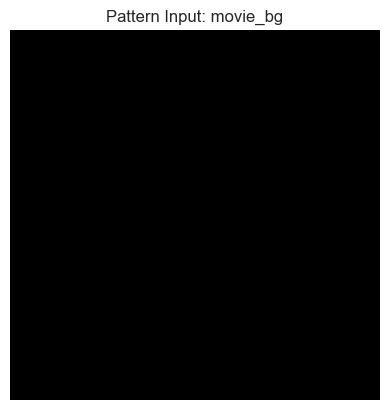

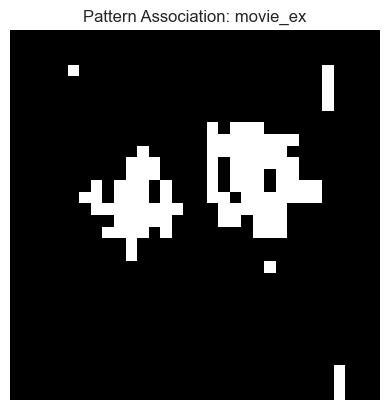

In [85]:
# INTERFERENCE 

# train network with ex as baseline 
W_base = train_hopfield(ex_patterns,repeats=10) # bc you were with him for awhile and the basin is deep

# save baseline weights 
np.save('W_base_v1.npy',W_base)

# input background only
bg = random.choice(bg_keys)
bg_input = memory_dict[bg]

ex_key = bg.replace('_bg','_ex')
ex_pattern = memory_dict[ex_key]


# how network recalls (recall_pattern function above)
output, steps = recall_pattern(W_base, bg_input) 
print(f'Converged in {steps} steps') # how many iterations to settle in memory pattern 
show_image(bg_input, title=f'Pattern Input: {bg}')
show_image(output, title=f'Pattern Association: {ex_key}')

In [86]:
# REINFORCEMENT 

def reinforce_memory(W, new_pattern, repeats=1):
    '''
    Reinforces new memory patterns WITHOUT erasing the past
    Simulates how human brains strengthen new associations over time
    without deleting the past (bc that's not possible)
    '''
    for _ in range(repeats):
        W += np.outer(new_pattern, new_pattern)
    np.fill_diagonal(W, 0) # no self-connections
    # no re-normalization bc will flatten everything out/would lose reinforcement effect 
    return W



In [87]:
# ADDING NOISE/ROBUSTNESS 
def add_noise(vector, amount=0):
    '''
    Inverting binary states of some perecentage of neurons to simulate noise
    '''
    v = vector.copy()
    n = len(v)
    flip_indices = np.random.choice(n, size=int(n * amount), replace=False)
    v[flip_indices] *= -1
    return v

In [88]:
W_temp = W_base.copy()  # doesn't overwrite original weights (repeat=10)

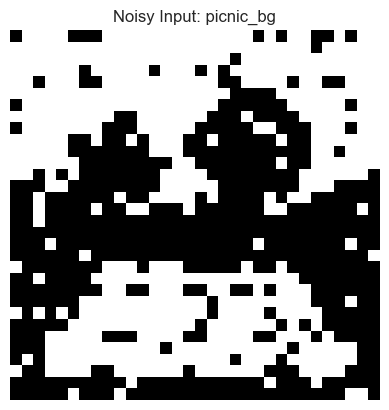

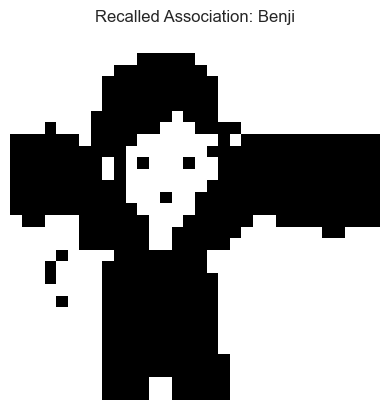

In [89]:
scene_names = ['beach', 'christmas', 'movie', 'night', 'surf', 'brunch', 'picnic']

log_data = []
turn_point = {scene: None for scene in scene_names}

for repeats in range(1, 31):
    bg = random.choice(bg_keys)     # random selection
    scene = bg.replace('_bg', '')

    # scene patterns
    bg_input = memory_dict[bg]
    noisy_bg = add_noise(bg_input, amount=0.1) # add noise to the "incomplete" input
    benji_key = bg.replace('_bg','_benji')
    ex_key = bg.replace('_bg','_ex')
    benji_pattern = memory_dict[benji_key]
    ex_pattern = memory_dict[ex_key]

    # reinforce benji
    W_temp = reinforce_memory(W_temp,
                            new_pattern=benji_pattern,
                            repeats=1) 

    # recall via noisy bg
    recalled, steps = recall_pattern(W_temp, pattern=noisy_bg)
    sim_ex_cos = cosine_similarity([recalled], [ex_pattern])[0][0]
    sim_benji_cos = cosine_similarity([recalled], [benji_pattern])[0][0]



    delta_cos = sim_benji_cos - sim_ex_cos


    # compare similarities
    if sim_ex_cos > sim_benji_cos:
        recalled_label = 'Ex'
    elif sim_benji_cos > sim_ex_cos:
        recalled_label = 'Benji'
    else:
        recalled_label = 'Unclear'


    if turn_point[scene] is None and recalled_label == 'Benji':
        turn_point[scene] = repeats

    log_data.append({
        'repeat': repeats,
        'scene': scene,
        'sim_to_ex_cos': sim_ex_cos,
        'sim_to_benji_cos': sim_benji_cos,
        'delta_cos': delta_cos,
        'recalled': recalled_label,
        'converged': steps,
        'turn_point': turn_point[scene]
    })



    # print(f'Repeat: {repeats:2d} | Noisy Input: {bg} | Similiarity to {benji_key}: {sim_benji:.2f} | Similarity to {ex_key}: {sim_ex:.2f} | Recalled: {recalled_label}')

df_log = pd.DataFrame(log_data)
df_log['hit_max_steps'] = df_log['converged'] >= 10
df_log.to_csv('exdnet_v1.csv', index=False)
# save trained weights 
np.save('W_temp_v1.npy', W_temp)

show_image(noisy_bg,title=f'Noisy Input: {bg}')
show_image(recalled,title=f'Recalled Association: {recalled_label}')

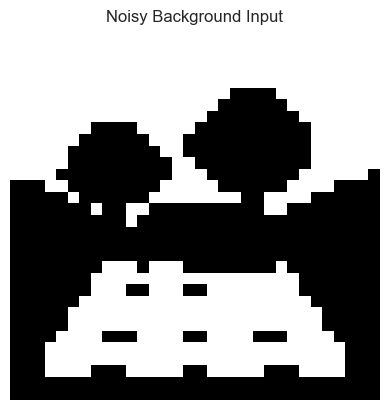

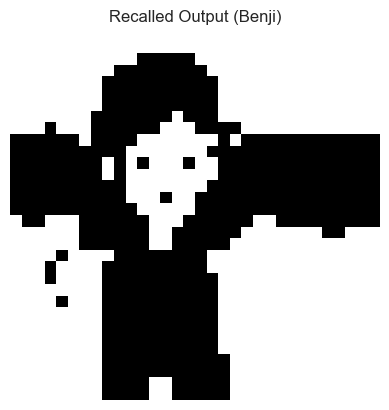

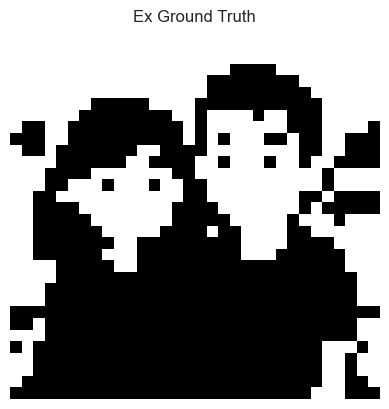

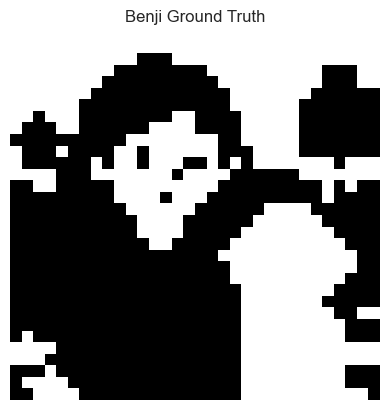

In [90]:
show_image(bg_input, title='Noisy Background Input')
show_image(recalled, title=f'Recalled Output ({recalled_label})')
show_image(ex_pattern, title='Ex Ground Truth')
show_image(benji_pattern, title='Benji Ground Truth')

### Model Analysis

In [91]:
output_dir = "/Users/edinh/Documents/HOPFIELD PROJECT/plots"

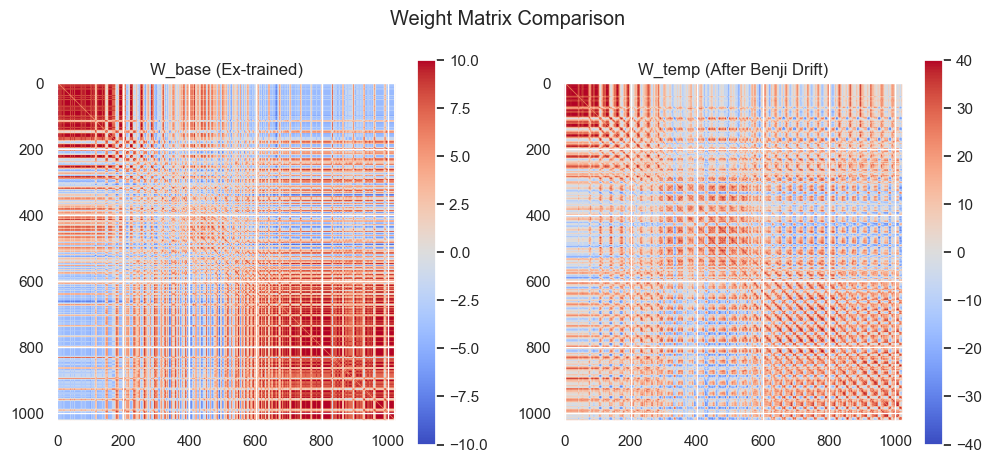

In [92]:
# compare W_base vs W_temp

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(W_base, cmap='coolwarm')
plt.title('W_base (Ex-trained)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(W_temp, cmap='coolwarm')
plt.title('W_temp (After Benji Drift)')
plt.colorbar()

plt.suptitle('Weight Matrix Comparison')
plt.savefig(f"{output_dir}/weight_before_after.png")
plt.show()

We can see how the initial weights drifted after destabilization was introduced. Ie after cognitive dissonance and adaptation of the new pattern.  

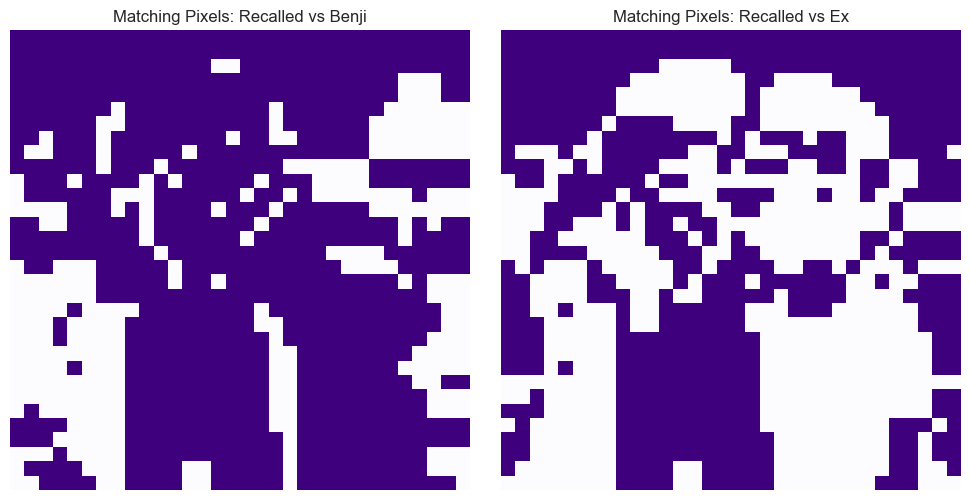

In [93]:
# purple = pattern match, white = no match i.e. the more filled in the more similar 

size = int(np.sqrt(len(recalled)))

match_benji = (recalled == benji_pattern).astype(int)
match_ex = (recalled == ex_pattern).astype(int)

match_benji_img = match_benji.reshape((size, size))
match_ex_img = match_ex.reshape((size, size))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cmap = 'Purples'

axes[0].imshow(match_benji_img, cmap=cmap, vmin=0, vmax=1)
axes[0].set_title('Matching Pixels: Recalled vs Benji')
axes[0].axis('off')

axes[1].imshow(match_ex_img, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title('Matching Pixels: Recalled vs Ex')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(f"{output_dir}/pixel_match.png")
plt.show()

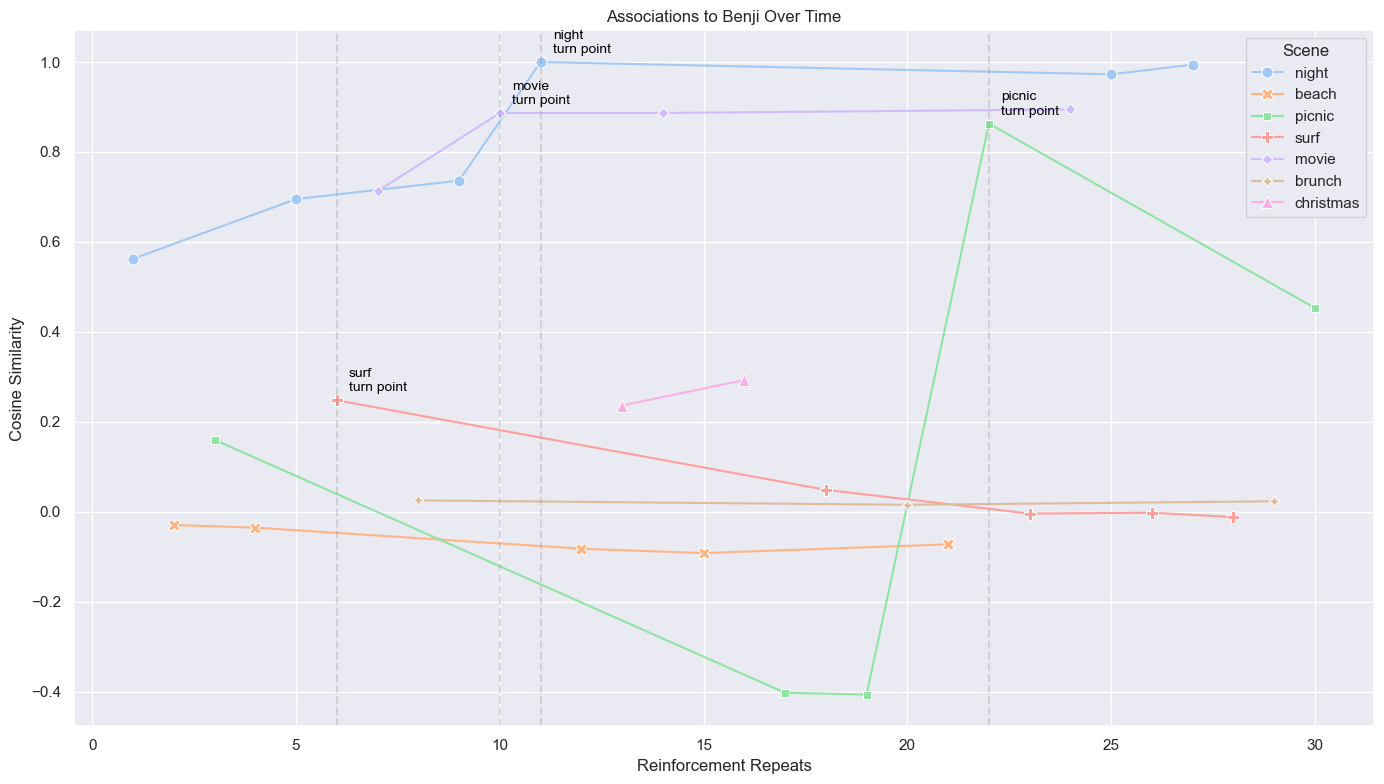

In [94]:
plt.figure(figsize=(14, 8))

plot = sns.lineplot(
    data=df_log,
    x='repeat',
    y='sim_to_benji_cos',
    hue='scene',
    style='scene',
    markers=True,
    dashes=False,
    palette='pastel'
)

for line in plot.lines:
    line.set_markersize(8)

for scene in scene_names:
    turn = turn_point.get(scene)
    if turn:
        y_val = df_log[(df_log['scene'] == scene) & (df_log['repeat'] == turn)]['sim_to_benji_cos'].values
        if len(y_val) > 0:
            plt.axvline(x=turn, linestyle='--', alpha=0.25, color='gray')
            plt.text(turn + 0.3, y_val[0] + 0.02, f'{scene}\nturn point', fontsize=10, color='black')



plt.title('Associations to Benji Over Time')
plt.ylabel('Cosine Similarity')
plt.xlabel('Reinforcement Repeats')
plt.legend(title='Scene')
plt.savefig(f"{output_dir}/benji_associations_main.png")
plt.tight_layout()
plt.show()

# print('Turn point = first time the network recalls Benji instead of Ex')

Surf had a quick turn point but decreased over time. Initial recall may have associated benji without <b><em>true reinforcement</em></b> so as the reinforcement interations continue the true shape/depth of the attractor basin re-establishes itself. 

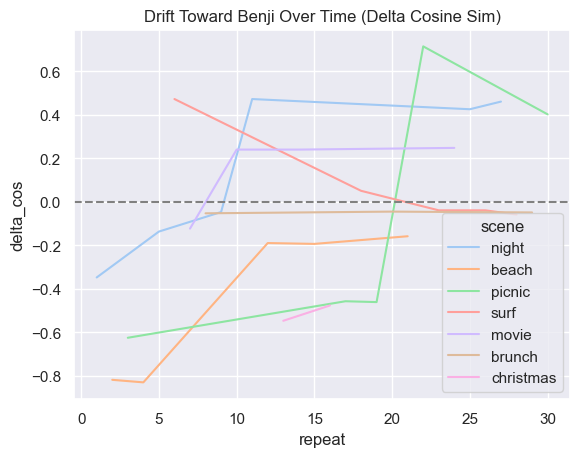

In [95]:
# positive delta cosine shows that the attractor drifted toward benji (negative = associated with the ex)

sns.lineplot(data=df_log, x='repeat', y='delta_cos', hue='scene',palette='pastel')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Drift Toward Benji Over Time (Delta Cosine Sim)")
plt.savefig(f"{output_dir}/benji_drift_delta_cosine.png")
plt.show()

Over time we see majority shifting towards the new benji pattern/positive besides surf which hovers near neutral (as explained above).


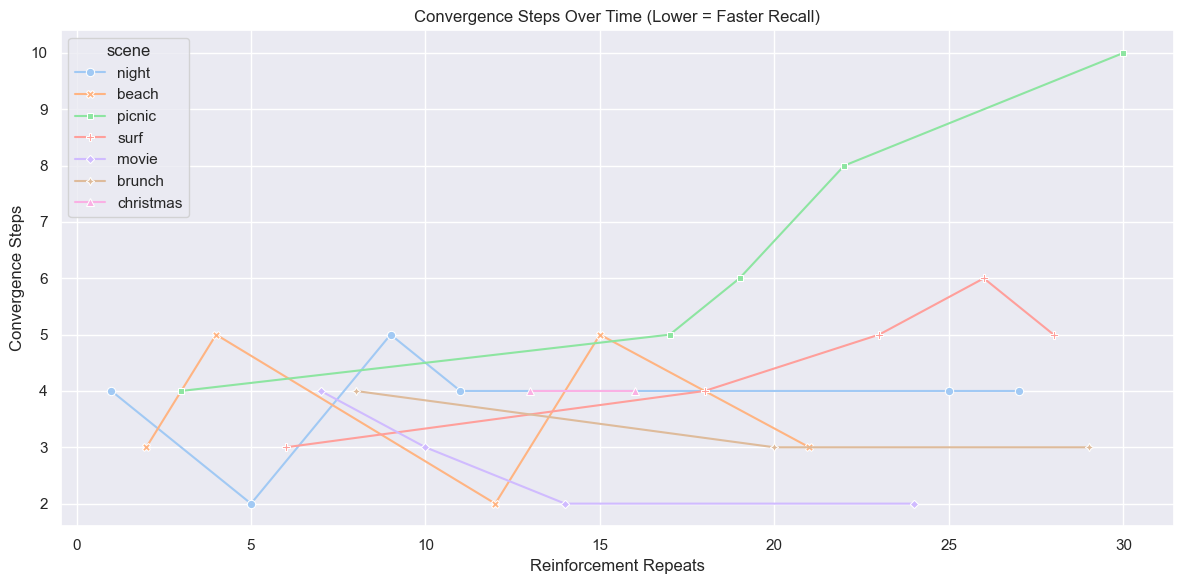

In [96]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_log,
    x='repeat',
    y='converged',
    hue='scene',
    style='scene',
    markers=True,
    dashes=False,
    palette='pastel'
)
plt.title('Convergence Steps Over Time (Lower = Faster Recall)')
plt.ylabel('Convergence Steps')
plt.xlabel('Reinforcement Repeats')
plt.savefig(f"{output_dir}/convergence.png")
plt.tight_layout()
plt.show()

In [97]:
df_log['rolling_convergence'] = (
    df_log.groupby('scene')['converged']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

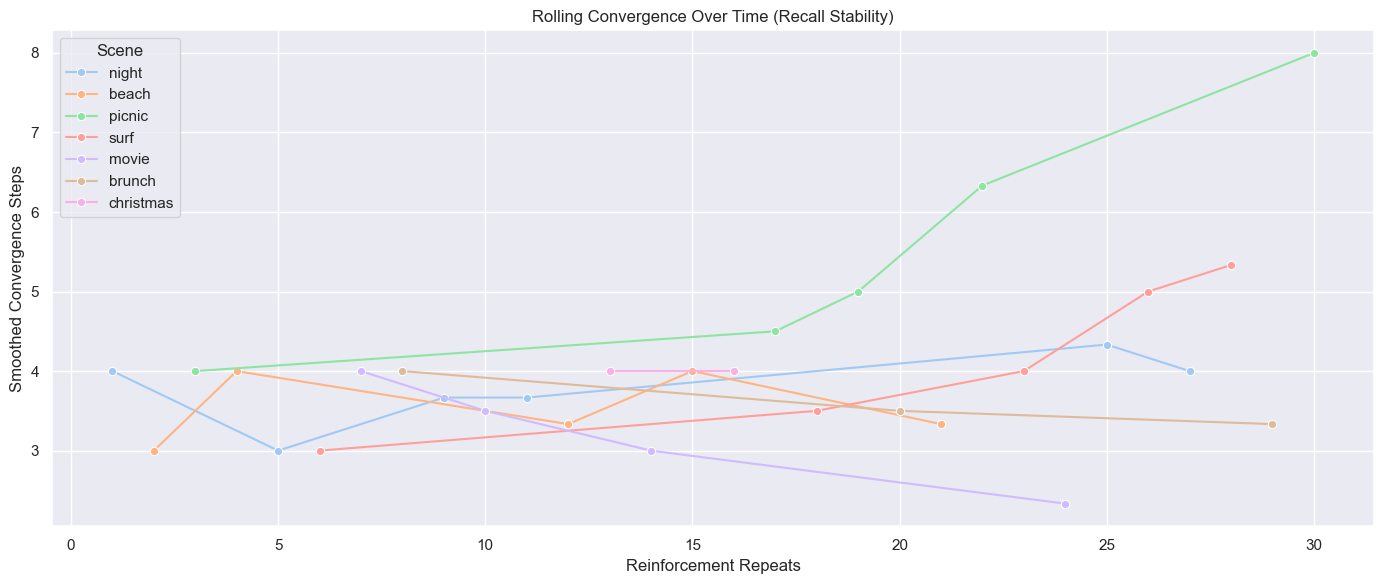

In [98]:
# rolling convergence (stability)
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_log, x='repeat', y='rolling_convergence', hue='scene', marker='o',palette='pastel')
plt.title('Rolling Convergence Over Time (Recall Stability)')
plt.ylabel('Smoothed Convergence Steps')
plt.xlabel('Reinforcement Repeats')
plt.legend(title='Scene')
plt.savefig(f"{output_dir}/converged_stability.png")
plt.tight_layout()
plt.show()

How stable and efficient the recall becomes over time. Stability indicates memory consolidation while instability indicates interference. Downward slope indicates more efficient recall/less steps to converge (movie). Upward slope indicates volatile memory (picnic). 

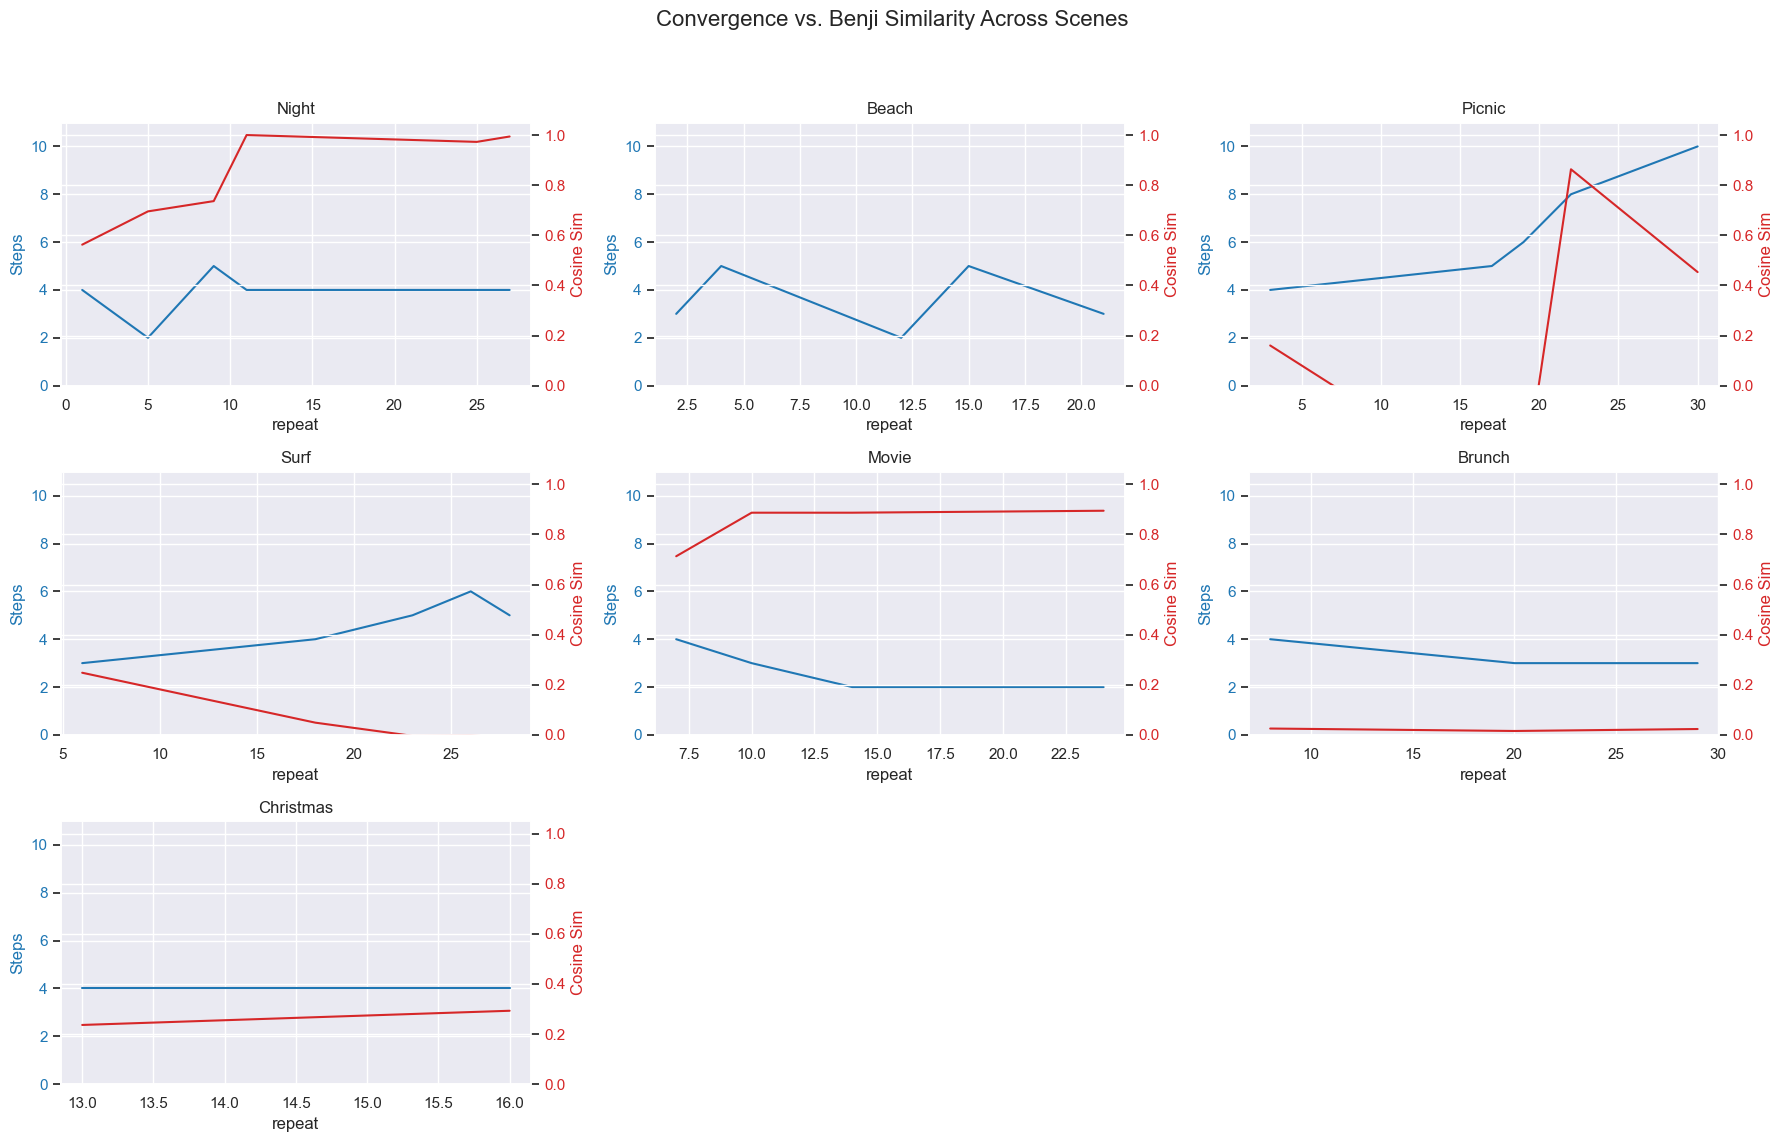

In [99]:
scenes = df_log['scene'].unique()
n_scenes = len(scenes)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axs = axs.flatten()

sim_ylim = (0, 1.05)
steps_ylim = (0, df_log['converged'].max() + 1)

for i, scene in enumerate(scenes):
    log = df_log[df_log['scene'] == scene]
    
    ax1 = axs[i]
    ax2 = ax1.twinx()
    
    sns.lineplot(data=log, x='repeat', y='converged', ax=ax1, color='tab:blue')
    sns.lineplot(data=log, x='repeat', y='sim_to_benji_cos', ax=ax2, color='tab:red')
    
    ax1.set_title(scene.capitalize())
    ax1.set_ylabel("Steps", color='tab:blue')
    ax2.set_ylabel("Cosine Sim", color='tab:red')
    ax1.set_ylim(steps_ylim)
    ax2.set_ylim(sim_ylim)
    ax1.set_xlabel("repeat")
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Convergence vs. Benji Similarity Across Scenes", fontsize=16)
plt.savefig(f"{output_dir}/scene_similarity_convergence.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

You can see how each scene/memory has different emotional "topology" i.e. some are have more deeper basins while others are more shallow. <br>
<br>•	Movie: Immediate Benji association (high sim), fast recall (low steps) — strong attractor from the start.
<br>•	Picnic: Sudden jump in similarity but not faster recall i.e. memory is rewiring but not yet efficient.
<br>•	Night: Early consolidation and efficient recall — stable positive memory.
<br>•	Beach / Surf: Shaky recall, low similarity — unstable or conflicted memories.
<br>•	Christmas: Weak signals, flat curve — emotionally ambiguous or repressed memory.
<br>•	Brunch: Neutral flatline — emotionally numb or discarded association.

In [100]:
def hopfield_energy(W, state):
    return -0.5 * state @ W @ state

In [101]:
energy_log = []

for scene in scene_names:
    E_ex = hopfield_energy(W_temp, memory_dict[f'{scene}_ex'])
    E_benji = hopfield_energy(W_temp, memory_dict[f'{scene}_benji'])
    delta = (E_benji - E_ex) / abs(E_ex)
    # print(f'{scene}: Ex memory energy: {E_ex:.2f}, Benji memory energy: {E_benji:.2f}')
    energy_log.append({'scene':scene, 'energy_ex':E_ex, 'energy_benji':E_benji, 'energy_delta':delta})

energy_df = pd.DataFrame(energy_log)
energy_df['turning_point'] = energy_df['scene'].map(turn_point).fillna(0).astype(int)
energy_df.to_csv('energy_df.csv', index=False)

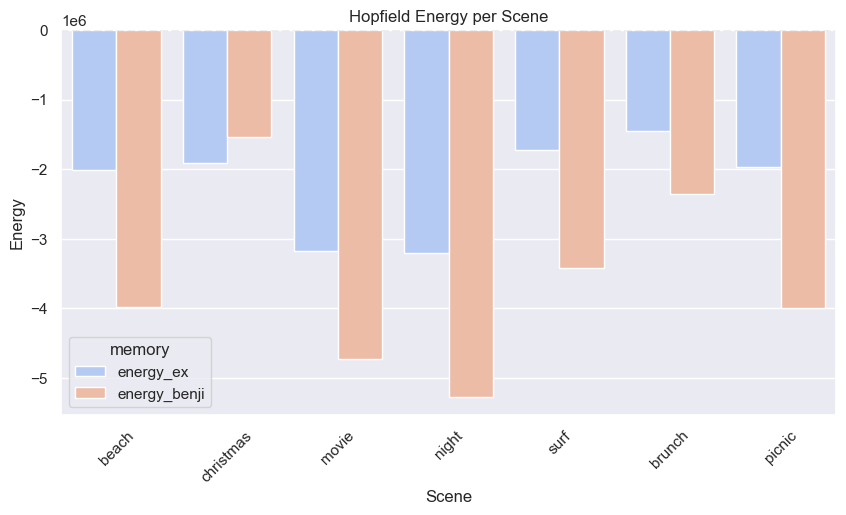

In [102]:
melt_energy_df = energy_df.melt(id_vars='scene',value_vars=['energy_ex', 'energy_benji'], 
                                var_name='memory',value_name='energy')
plt.figure(figsize=(10,5))
sns.barplot(melt_energy_df, x='scene',y='energy', hue='memory',palette='coolwarm')
plt.axhline(0,color='gray',linestyle='--')

plt.title('Hopfield Energy per Scene')
plt.xlabel('Scene')
plt.ylabel('Energy')
plt.xticks(rotation=45)
plt.savefig(f"{output_dir}/scene_energy_ex_benji.png")
plt.show()

/var/folders/x4/z8t0tx8s7hsgqgb4jbv_x5l40000gn/T/ipykernel_2781/3692044497.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(energy_df, x='scene',y='energy_delta', palette='coolwarm')


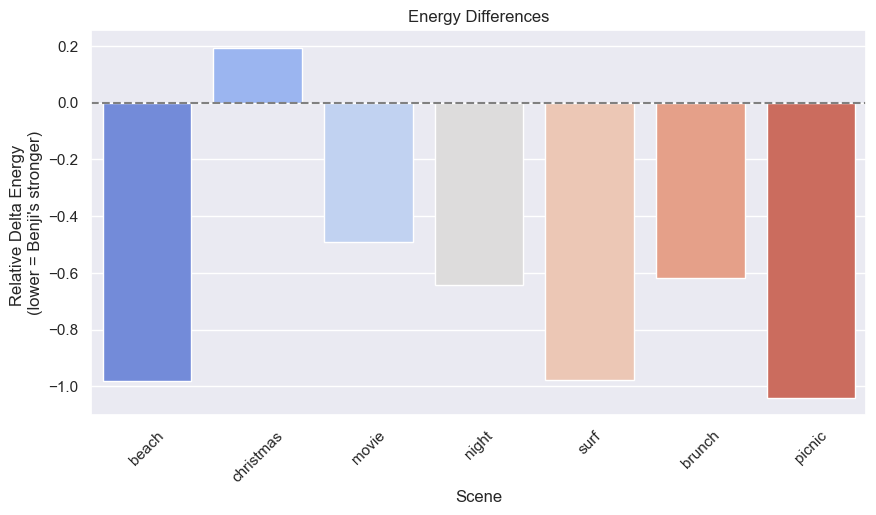

In [103]:
plt.figure(figsize=(10,5))
sns.barplot(energy_df, x='scene',y='energy_delta', palette='coolwarm')
plt.axhline(0,color='gray',linestyle='--')
plt.title('Energy Differences')
plt.ylabel('Relative Delta Energy \n(lower = Benji\'s stronger)')
plt.xlabel('Scene')
plt.xticks(rotation=45)
plt.savefig(f"{output_dir}/scene_energy_delta.png")
plt.show()

We see how the energy differences compare between benji/the ex 

In [104]:
delta_cos = df_log.groupby('scene')['delta_cos'].mean().reset_index()
energy_analysis = energy_df.merge(delta_cos, on='scene')

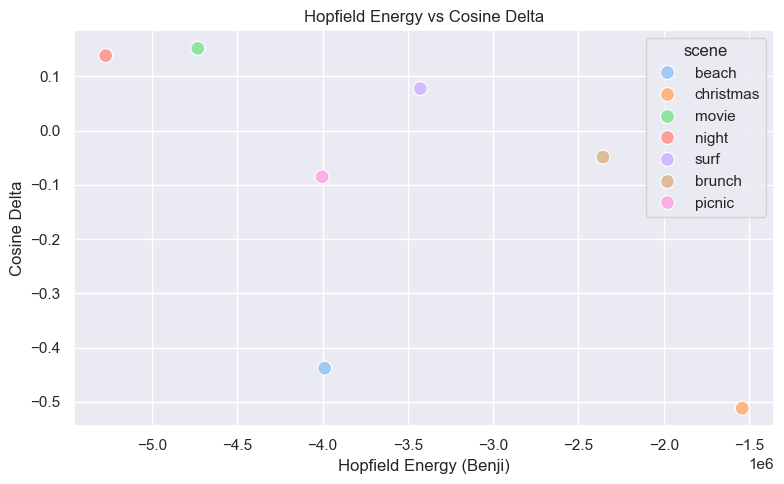

In [105]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=energy_analysis, x='energy_benji', y='delta_cos', hue='scene', s=100,palette='pastel')
plt.title('Hopfield Energy vs Cosine Delta')
plt.xlabel('Hopfield Energy (Benji)')
plt.ylabel('Cosine Delta')
plt.savefig(f"{output_dir}/scene_energy_cosine_delta.png")
plt.tight_layout()
plt.show()

If we divide this up into quadrants we see that: <br>
<br>Lower left: low energy = stronger benji basin but negative delta cosine = association still favor ex
<br> Upper left: low energy = strong benji basin and more positive delta cosine favoring benji i.e. association drifted towards the new pattern (benji)
<br> Lower right: weak benji basin and negative delta cosine favoring ex association
<br> Upper right: weak benji basin and more positive delta cosine favoring benji i.e. the benji basin is developing and is fragile/recently associating